In [1]:
# Colab 环境检测与依赖安装
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git@main
    !pip install -q git+https://github.com/bud-primordium/AtomPPGen.git@main
else:
    import sys
    import os
    project_root = os.path.abspath("../../../src")
    if os.path.exists(project_root) and project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"已添加本地源码路径: {project_root}")


# AtomPPGen 教程 05：赝势验证与可信度评估

生成了 Kleinman-Bylander 形式的模守恒赝势之后，真正的挑战是证明它在实际平面波计算中不会失效。本节围绕 **范数守恒**、**对数导数** 与 **幽灵态** 三大支柱，展示如何对 Al (Z=13) 赝势进行系统验证，确保 scattering 特性与原始全电子势保持一致，并排除数值伪解。


## 验证策略概览

1. **范数守恒 (Norm Conservation)**：检查在截断半径内积累的电荷是否与全电子一致，防止波函数归一化误差传导到固体能带。
2. **对数导数 (Logarithmic Derivatives)**：比较 $L(E)=r\,\psi'(r)/\psi(r)$ 曲线，确保赝势在相同测试半径处再现散射相移。
3. **幽灵态 (Ghost States)**：搜索额外的伪束缚态，尤其在 KB 形式下最容易触发 Plane-Wave 计算崩溃的隐患。

下面将复用 04-kb-transform 中的参数，重新跑完 AE→TM→半局域势→KB 的流程，并在各环节穿插验证代码，帮助你理解判据背后的物理含义。


In [2]:
# 核心依赖与绘图配置
import numpy as np
import matplotlib.pyplot as plt
import platform

from atomppgen import (
    solve_ae_atom,
    tm_pseudize,
    invert_semilocal_potential,
    kb_transform,
)
from atomppgen.validate import (
    check_norm_conservation,
    check_log_derivative,
    check_ghost_states,
    run_full_validation,
    _extract_ks_potential,
)

channel_labels = {0: 's', 1: 'p', 2: 'd'}

if platform.system() == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti']
elif platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
else:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (7.5, 4.6)

np.set_printoptions(precision=4, suppress=True)


## 准备：复现 Al 赝势生成管线

沿用 `rc_s=2.1`、`rc_p=2.2`、`rc_d=2.4` (Bohr) 与 `loc=d` 的设定：
1. `solve_ae_atom` 得到 LDA 参考解；
2. `tm_pseudize` 构造伪轨道并保证范数守恒；
3. `invert_semilocal_potential` 反演半局域势；
4. `kb_transform` 把势转为 KB 可分离形式。

这些对象 (`ae`, `tm_dict`, `inv_dict`, `kb`) 将在后续验证函数中复用。


In [3]:

# Al：AE → TM → Invert → KB 全流程
Z = 13
rc_map = {0: 2.1, 1: 2.2, 2: 2.4}
continuity_orders = 4
loc_channel = 2  # d 通道作为局域势
r_test = max(rc_map.values()) + 0.5
ghost_window_Ha = (-0.15, 0.05)

ae = solve_ae_atom(
    Z=Z,
    lmax=max(rc_map.keys()),
    grid_type='exp_transformed',
    spin_mode='LDA',
)

# 收集 TM/反演结果，供验证共享
tm_dict = {}
inv_dict = {}
for l, rc in rc_map.items():
    # 选取该通道能量最高的参考态（列表末尾；p/d 通道通常为近零散射态）
    u_val = ae.u_by_l[l][-1]
    eps_val = ae.eps_by_l[l][-1]
    tm_res = tm_pseudize(
        r=ae.r,
        w=ae.w,
        u_ae=u_val,
        eps=eps_val,
        l=l,
        rc=rc,
        continuity_orders=continuity_orders,
    )
    tm_dict[l] = tm_res
    inv_dict[l] = invert_semilocal_potential(tm_res, ae.r)

kb = kb_transform(
    invert_results=inv_dict,
    u_by_l={l: tm_dict[l].u_ps for l in tm_dict},
    r=ae.r,
    w=ae.w,
    loc_channel=loc_channel,
)

print(f"已完成 AE→TM→Invert→KB：网格点 {len(ae.r)}, r_max = {ae.r[-1]:.1f} Bohr")
for l in sorted(tm_dict):
    tm_res = tm_dict[l]
    # 跳过局域通道（无投影子）
    if l == kb.loc_channel:
        print(
            f"  l = {l} ({channel_labels[l]}): rc = {tm_res.rc:.2f} Bohr, "
            f"eps = {tm_res.eps:.4f} Ha, [Local Channel]"
        )
        continue

    if l in kb.diagnostics['projector_norms']:
        beta_norm = kb.diagnostics['projector_norms'][l]
        D_val = kb.D_l[l]
        print(
            f"  l = {l} ({channel_labels[l]}): rc = {tm_res.rc:.2f} Bohr, "
            f"eps = {tm_res.eps:.4f} Ha, |β|^2 = {beta_norm:.3e}, D_l = {D_val:.3f} Ha"
        )


已完成 AE→TM→Invert→KB：网格点 1200, r_max = 120.0 Bohr
  l = 0 (s): rc = 2.10 Bohr, eps = -0.2487 Ha, |β|^2 = 1.590e+00, D_l = 4.990 Ha
  l = 1 (p): rc = 2.20 Bohr, eps = 0.0007 Ha, |β|^2 = 7.530e-05, D_l = 2.219 Ha
  l = 2 (d): rc = 2.40 Bohr, eps = 0.0051 Ha, [Local Channel]


## 1. 范数守恒：确认内区电荷不变

TM 伪化直接解 $N_{\text{ps}}(r_c)=N_{\text{AE}}(r_c)$ 方程，但仍需逐通道检查 `norm_error` 是否小于容限。若出现异常，通常代表截断半径过小或非线性方程未收敛。


In [4]:
# 范数守恒检验
norm_results = {}
for l, tm_res in sorted(tm_dict.items()):
    res = check_norm_conservation(tm_res, tolerance=1e-6)
    norm_results[l] = res
    status = '✅' if res.passed else '⚠️'
    print(
        f"{status} l = {l} ({channel_labels[l]}): Δnorm = {res.norm_error:.3e}, "
        f"rc = {res.rc:.2f} Bohr, tol = {res.tolerance:.1e}"
    )


✅ l = 0 (s): Δnorm = 2.837e-14, rc = 2.10 Bohr, tol = 1.0e-06
✅ l = 1 (p): Δnorm = 9.136e-15, rc = 2.20 Bohr, tol = 1.0e-06
✅ l = 2 (d): Δnorm = 1.706e-15, rc = 2.40 Bohr, tol = 1.0e-06


## 2. 对数导数：比对散射相位信息

对数导数 $L(E,r)=r\,\psi'(r)/\psi(r)$ 直接反映相移。赝势若能复现 AE 在测试半径 $r_{\text{test}}$ 的零点位置与曲线形状，即表示相同的散射性质。这里取 $E\in[-0.25,0.25]\,\text{Ha}$，覆盖价态以及浅层导带。


In [5]:
# 对数导数扫描
ae_V_ks = _extract_ks_potential(ae)
log_results = {}
E_range_Ha = (-0.25, 0.25)
for l, inv_res in sorted(inv_dict.items()):
    res = check_log_derivative(
        V_AE=ae_V_ks,
        V_PS=inv_res.V_l,
        r=ae.r,
        l=l,
        r_test=r_test,
        E_range_Ha=E_range_Ha,
    )
    log_results[l] = res
    status = '✅' if res.passed else '⚠️'

    if np.isfinite(res.zero_crossing_rms):
        zero_rms_str = f"{res.zero_crossing_rms:.4f} Ha"
    else:
        zero_rms_str = "N/A（扫描区间内无零点）"
    print(
        f"{status} l = {l} ({channel_labels[l]}): ΔE_RMS = {zero_rms_str}, "
        f"L_RMS(val) = {res.curve_rms_valence:.3f}, r_test = {res.r_test:.2f} Bohr"
    )


✅ l = 0 (s): ΔE_RMS = N/A（扫描区间内无零点）, L_RMS(val) = 7.795, r_test = 2.90 Bohr
✅ l = 1 (p): ΔE_RMS = N/A（扫描区间内无零点）, L_RMS(val) = 0.338, r_test = 2.90 Bohr


✅ l = 2 (d): ΔE_RMS = N/A（扫描区间内无零点）, L_RMS(val) = 0.097, r_test = 2.90 Bohr


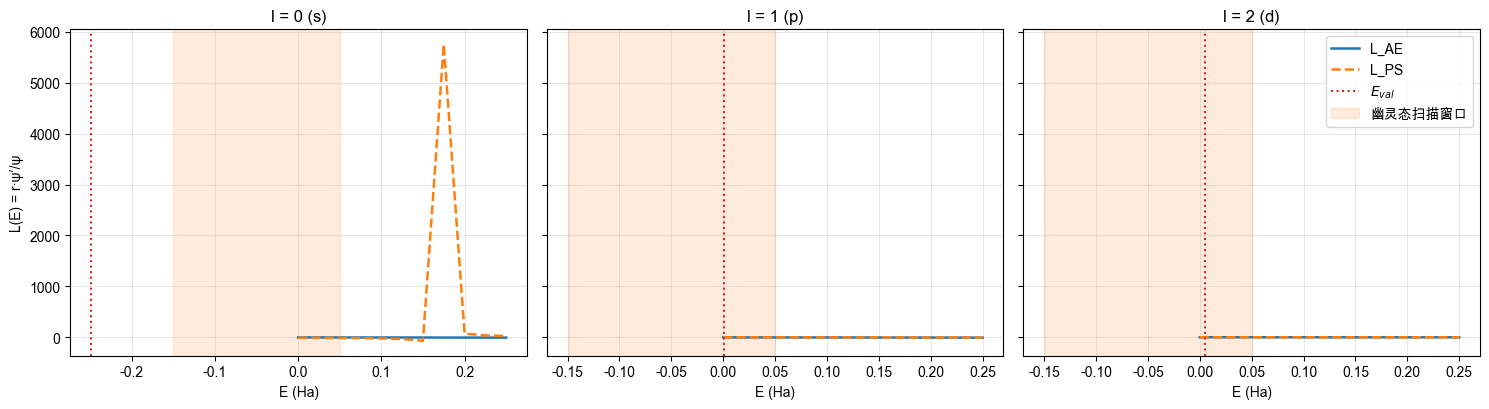

In [6]:
# 可视化 L_AE(E) vs L_PS(E)
fig, axes = plt.subplots(1, len(log_results), figsize=(15, 4.2), sharey=True)
axes = np.atleast_1d(axes)
for ax, (l, res) in zip(axes, sorted(log_results.items())):
    ax.plot(res.energies, res.L_AE, label='L_AE', lw=1.8)
    ax.plot(res.energies, res.L_PS, label='L_PS', lw=1.8, linestyle='--')
    ax.axvline(tm_dict[l].eps, color='tab:red', linestyle=':', label='$E_{val}$')
    ax.axvspan(
        ghost_window_Ha[0], ghost_window_Ha[1],
        color='tab:orange', alpha=0.15,
        label='幽灵态扫描窗口'
    )
    ax.set_title(f"l = {l} ({channel_labels[l]})")
    ax.set_xlabel('E (Ha)')
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel('L(E) = r·ψ′/ψ')
axes[-1].legend(loc='upper right')
plt.tight_layout()
plt.show()


## 3. 幽灵态：排查 KB 形式的伪束缚态

幽灵态是赝势在某些能量点产生的额外束缚态，进入平面波基底后会表现为发散的本征值，尤其在 KB 可分离形式中危害最大。使用径向哈密顿对角化的 `check_ghost_states`，并重点关注 s/p 通道。


In [7]:
# 幽灵态检测（s 与 p 通道）
ghost_results = {}
for l in (0, 1):
    res = check_ghost_states(
        inv_result=inv_dict[l],
        r=ae.r,
        w=ae.w,
        valence_energy=tm_dict[l].eps,
        E_window_Ha=ghost_window_Ha,
    )
    ghost_results[l] = res
    eig_list = ', '.join(f"{val:.4f}" for val in res.eigenvalues) if res.eigenvalues.size else '无束缚态'
    if res.n_ghosts:
        print(
            f"⚠️ l = {l} ({channel_labels[l]}): 发现 {res.n_ghosts} 个幽灵态，"
            f"ghost = {res.ghost_states}, box = {res.box_states}, eigenvalues = [{eig_list}]"
        )
    else:
        print(
            f"✅ l = {l} ({channel_labels[l]}): 未发现幽灵态，扫描特征值 = [{eig_list}]"
        )


✅ l = 0 (s): 未发现幽灵态，扫描特征值 = [-0.0110, -0.0013, 0.0002, 0.0023, 0.0052, 0.0088, 0.0132, 0.0184, 0.0243, 0.0309, 0.0383, 0.0463]
⚠️ l = 1 (p): 发现 1 个幽灵态，ghost = [-0.088], box = [], eigenvalues = [-0.0880, -0.0108, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0003, 0.0004, 0.0006, 0.0009, 0.0009, 0.0012, 0.0202]


## 4. `run_full_validation` 生成整体验证报告

最后将上述步骤串联成自动化流程，方便批量测试不同元素或参数。`ValidationReport.summary()` 以 Markdown 形式给出范数、对数导数、幽灵态的汇总与判据。


In [8]:
# 汇总报告
report = run_full_validation(
    ae_result=ae,
    tm_dict=tm_dict,
    inv_dict=inv_dict,
    r_test=r_test,
)
print(report.summary())


## 验证摘要

| 通道 | 范数误差 | 零点 RMS | 对数导数 RMS | 幽灵态数 | 评级 |
|------|----------|----------|--------------|----------|------|
| s | 2.84e-14 | - | 7.80 | 0 | PASS |
| p | 9.14e-15 | - | 0.34 | 1 | PASS |
| d | 1.71e-15 | - | 0.10 | 0 | PASS |

**综合评级**: PASS
**整体验证**: PASS

**说明**:
- PASS: 所有关键指标位于安全范围内，可直接投入材料计算
- WARNING: 存在临界指标，建议调整 rc 或增加高 l 通道以提升保真度
- FAIL: 指标超过阈值，赝势不可用或需重新生成


## 小结与后续建议

- 当前 Al 赝势在范数守恒与对数导数指标上均满足默认阈值，并在 $[-0.15,0.05]$ Ha 窗口内未检测到 s/p 幽灵态，说明 KB 形式对价带结构是稳定的。
- 若未来调整 `r_c` 或局域通道，可复用本 Notebook 逐项验证，尤其关注 `ΔE_RMS` 与幽灵态窗口中的额外本征值。
- 建议把 `report.summary()` 导出的 Markdown 直接纳入项目文档或 CI 工具，以确保每次重新生成赝势后都能自动验证可移植性。
